# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers
import time
from keras.optimizers import Adam
from PIL import Image

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
#Import the dataset and read the image into a seperate variable

images="./data/images"

all_imgs = glob.glob(images + '/*.jpg', recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


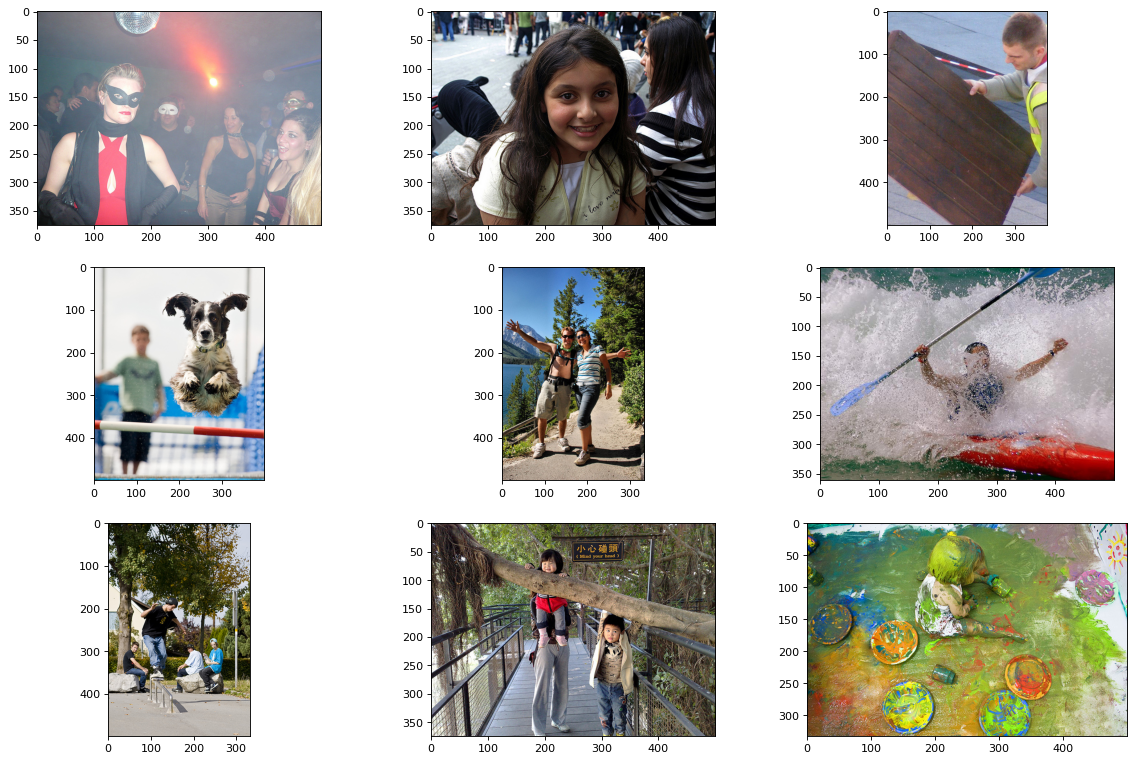

In [3]:
#Visualise both the images & text present in the dataset

figure(figsize=(18, 12), dpi=80)

for i in range(1, 10):
    image = plt.imread(all_imgs[i-1])
    plt.subplot(3, 3, i)
    plt.imshow(image) 
    
plt.show()
text_file = "./data/captions.txt"

In [4]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    file = open(filename, 'r')
    text = file.readlines()
    return text

doc = load_doc(text_file)
print(doc[:30])
doc.pop(0)

['image,caption\n', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted

'image,caption\n'

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
all_img_id = [caption.split(".")[0] for caption in doc]
all_img_vector = [images + "/" + caption.split(",")[0] for caption in doc]
annotations = [caption.split(",")[1] for caption in doc]

df = pd.DataFrame(list(zip(all_img_id, all_img_vector, annotations)),columns =['ID', 'Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e,./data/images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,./data/images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n
2,1000268201_693b08cb0e,./data/images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse...
3,1000268201_693b08cb0e,./data/images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,./data/images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472,./data/images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face\n
40451,997722733_0cb5439472,./data/images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .\n
40452,997722733_0cb5439472,./data/images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472,./data/images/997722733_0cb5439472.jpg,A rock climber in a red shirt .\n


In [6]:
#Create a list which contains all the captions
annotations = list(df["Captions"].apply(lambda z:"<start>"+" "+z+" "+"<end>"))

#add the <start> & <end> token to all those captions as well
annotations = [annotation.replace("\n", "").replace(" .", ".") for annotation in annotations]

#Create a list which contains all the path to the images
all_img_path = list(df["Path"].unique())

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [7]:
#Create the vocabulary & the counter for the captions
vocabulary = [word for caption in df["Captions"] for word in word_tokenize(caption)]

val_count = Counter(vocabulary)
val_count

Counter({'A': 22666,
         'child': 1449,
         'in': 18170,
         'a': 38764,
         'pink': 701,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 1871,
         'entry': 1,
         'way': 48,
         '.': 34289,
         'girl': 3174,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1607,
         'playhouse': 6,
         'the': 14587,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3491,
         'dog': 7804,
         'and': 8057,
         'spotted': 36,
         'are': 3364,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7303,
         'each': 399,
         'other': 666,
         'on': 10354,
         'road': 380,
         'white': 3646,
         'brown': 2383,
         'spots': 28,
         'staring'

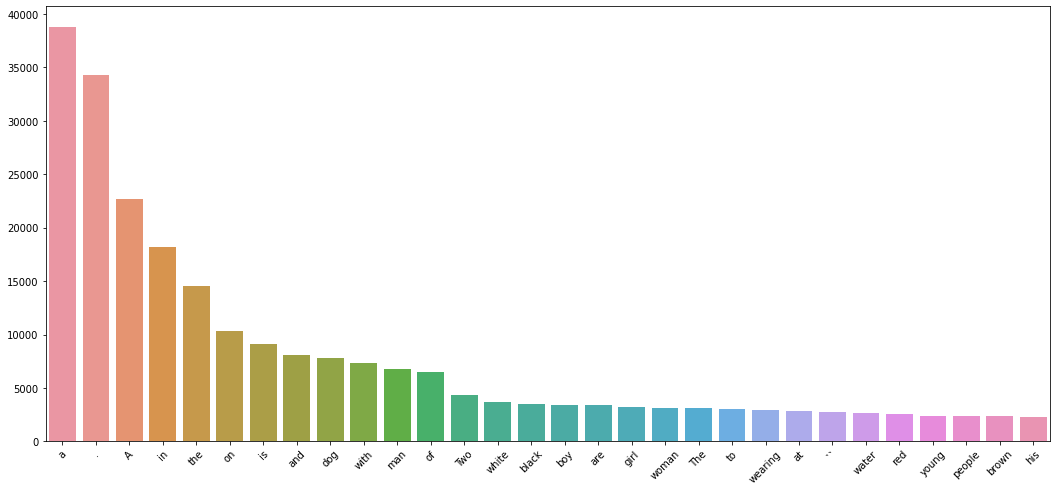

In [8]:
#Visualise the top 30 occuring words in the captions
val_count = {key: value for key, value in sorted(val_count.items(), key=lambda item: item[1], reverse=True)}
most_frequent = dict(list(val_count.items())[:30])

plt.figure(figsize=(18,8))
sns.barplot(x=list(most_frequent.keys()),y=list(most_frequent.values()))
plt.xticks(rotation=45)
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [9]:
# create the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 5000, oov_token = "UNK", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [10]:
# Create word-to-index and index-to-word mappings.

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [11]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

list(tokenizer.word_counts.items())[:30]

[('<start>', 40455),
 ('a', 61436),
 ('child', 1517),
 ('in', 18193),
 ('pink', 706),
 ('dress', 332),
 ('is', 9069),
 ('climbing', 495),
 ('up', 1251),
 ('set', 106),
 ('of', 6504),
 ('stairs', 109),
 ('an', 2358),
 ('entry', 1),
 ('way', 51),
 ('<end>', 40455),
 ('girl', 3284),
 ('going', 145),
 ('into', 1046),
 ('wooden', 278),
 ('building', 485),
 ('little', 1750),
 ('playhouse', 6),
 ('the', 17677),
 ('to', 3008),
 ('her', 1102),
 ('cabin', 4),
 ('black', 3641),
 ('dog', 7958),
 ('and', 8066)]

In [12]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
array_length = [len(element) for element in train_seqs]
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding = 'post', maxlen = max(array_length))

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [13]:
#write your code here to create the dataset consisting of image paths

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


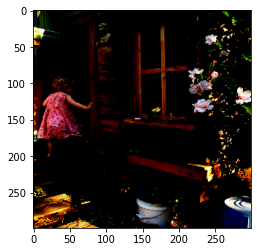

In [14]:
#write your code here for creating the function. This function should return images & their path
def load_image(image_path):
    preprocessed_image = tf.io.read_file(image_path)
    preprocessed_image = tf.image.decode_jpeg(preprocessed_image, channels=3)
    preprocessed_image = tf.image.resize(preprocessed_image, (299, 299))
    preprocessed_image = tf.keras.applications.inception_v3.preprocess_input(preprocessed_image)
    
    return preprocessed_image, image_path

plt.imshow(load_image(df["Path"][0])[0])
plt.show()

In [15]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

image_data = tf.data.Dataset.from_tensor_slices(sorted(set(all_img_vector)))
image_data = image_data.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(32)
image_data

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [16]:
image_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = keras.Model(new_input, hidden_layer)

In [17]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

feature_dict = {}

for img, path in tqdm(image_data):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  bf.numpy()
        #np.save(path_of_feature, bf.numpy())

100%|██████████| 253/253 [08:36<00:00,  2.04s/it]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [18]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,
                                                            cap_vector,
                                                            test_size=0.2,
                                                            random_state=33)

In [19]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [20]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_name, caption):
    img_tensor = feature_dict[image_name.decode('utf-8')]
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [21]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 32
BUFFER_SIZE = 1000

def gen_dataset(images_data, captions_data):
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [22]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [23]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [24]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE #(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [25]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim , activation='relu')
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features)
        
        return features

In [26]:
encoder=Encoder(embedding_dim)

### Attention model

In [27]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        # build your score funciton to shape: (batch_size, 8*8, units)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = keras.activations.softmax(self.V(score), axis=1)
        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

### Decoder

In [28]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        print("Init")
        super(Decoder, self).__init__()
        self.units=units
        #iniitalise your Attention model with units
        self.attention = Attention_model(self.units)
        #build your Embedding layer
        self.embed = layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        #build your Dense layer
        self.d1 = layers.Dense(self.units)
        #build your Dense layer
        self.d2 = layers.Dense(vocab_size)

    def call(self,x,features, hidden):
        #create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        output = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output) 
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [29]:
decoder=Decoder(embedding_dim, units, vocab_size)

Init


In [30]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [31]:
#define the optimizer
optimizer = keras.optimizers.Adam()
#define your loss object
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [32]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [33]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [34]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [35]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [36]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [37]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [38]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.283, & test loss is 1.070
Time taken for 1 epoch 1149.4472830295563 sec

Test loss has been reduced from 100.000 to 1.070


  7%|▋         | 1/15 [19:09<4:28:16, 1149.73s/it]

For epoch: 2, the train loss is 0.997, & test loss is 0.943
Time taken for 1 epoch 1056.1527519226074 sec

Test loss has been reduced from 1.070 to 0.943


 13%|█▎        | 2/15 [36:46<3:57:13, 1094.90s/it]

For epoch: 3, the train loss is 0.903, & test loss is 0.866
Time taken for 1 epoch 1052.3013207912445 sec

Test loss has been reduced from 0.943 to 0.866


 20%|██        | 3/15 [54:18<3:35:07, 1075.60s/it]

For epoch: 4, the train loss is 0.836, & test loss is 0.806
Time taken for 1 epoch 1055.8076701164246 sec

Test loss has been reduced from 0.866 to 0.806


 27%|██▋       | 4/15 [1:11:55<3:15:47, 1067.92s/it]

For epoch: 5, the train loss is 0.781, & test loss is 0.756
Time taken for 1 epoch 1062.9422919750214 sec

Test loss has been reduced from 0.806 to 0.756


 33%|███▎      | 5/15 [1:29:38<2:57:42, 1066.24s/it]

For epoch: 6, the train loss is 0.733, & test loss is 0.710
Time taken for 1 epoch 1062.8682589530945 sec

Test loss has been reduced from 0.756 to 0.710


 40%|████      | 6/15 [1:47:21<2:39:46, 1065.22s/it]

For epoch: 7, the train loss is 0.690, & test loss is 0.672
Time taken for 1 epoch 1064.243187904358 sec

Test loss has been reduced from 0.710 to 0.672


 47%|████▋     | 7/15 [2:05:06<2:22:00, 1065.01s/it]

For epoch: 8, the train loss is 0.650, & test loss is 0.633
Time taken for 1 epoch 1065.5240230560303 sec

Test loss has been reduced from 0.672 to 0.633


 53%|█████▎    | 8/15 [2:22:51<2:04:17, 1065.29s/it]

For epoch: 9, the train loss is 0.615, & test loss is 0.600
Time taken for 1 epoch 1076.136754989624 sec

Test loss has been reduced from 0.633 to 0.600


 60%|██████    | 9/15 [2:40:48<1:46:52, 1068.79s/it]

For epoch: 10, the train loss is 0.583, & test loss is 0.569
Time taken for 1 epoch 1081.4787237644196 sec

Test loss has been reduced from 0.600 to 0.569


 67%|██████▋   | 10/15 [2:58:50<1:29:24, 1072.82s/it]

For epoch: 11, the train loss is 0.555, & test loss is 0.543
Time taken for 1 epoch 1067.7187960147858 sec

Test loss has been reduced from 0.569 to 0.543


 73%|███████▎  | 11/15 [3:16:38<1:11:25, 1071.37s/it]

For epoch: 12, the train loss is 0.527, & test loss is 0.524
Time taken for 1 epoch 1062.145525932312 sec

Test loss has been reduced from 0.543 to 0.524


 80%|████████  | 12/15 [3:34:20<53:25, 1068.66s/it]  

For epoch: 13, the train loss is 0.502, & test loss is 0.494
Time taken for 1 epoch 1062.2618708610535 sec

Test loss has been reduced from 0.524 to 0.494


 87%|████████▋ | 13/15 [3:52:03<35:33, 1066.83s/it]

For epoch: 14, the train loss is 0.481, & test loss is 0.475
Time taken for 1 epoch 1068.870628118515 sec

Test loss has been reduced from 0.494 to 0.475


 93%|█████████▎| 14/15 [4:09:52<17:47, 1067.54s/it]

For epoch: 15, the train loss is 0.460, & test loss is 0.454
Time taken for 1 epoch 1064.1189246177673 sec

Test loss has been reduced from 0.475 to 0.454


100%|██████████| 15/15 [4:27:37<00:00, 1070.47s/it]


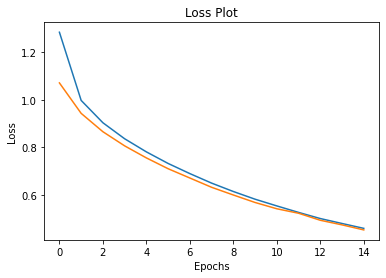

In [39]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [40]:
def evaluate(image):
    max_length=max(array_length)
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    #process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # Extract features using our feature extraction model
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(predictions[0]).numpy()
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [41]:
def beam_evaluate(image, beam_index = 4):

    max_length=max(array_length)
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
                  
    return final_caption

In [42]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [43]:
from nltk.translate.bleu_score import sentence_bleu

In [44]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [45]:
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

BELU score: 17.74488850711505
Real Caption: a black and white dog running on the beach while a man stands behind it
Prediction Caption: a dog running on the beach


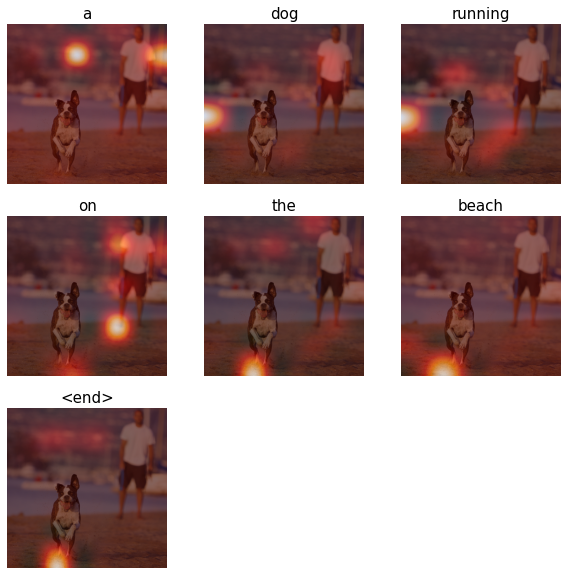

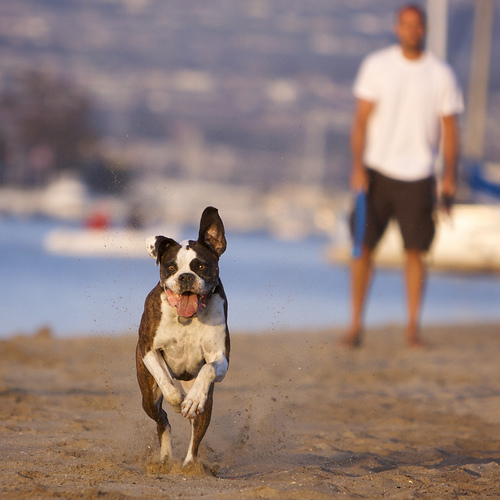

In [50]:
rid = np.random.randint(0, len(path_test))
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

test_image = path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BELU score: {score*100}")

print("Real Caption: " + real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [51]:
captions=beam_evaluate(test_image)
print(captions)

['<start>', 'the', 'dog', 'runs']
